# This notebook demonstrates predictive models and their performance, then use nested cv for hyperparameter tuning to optimize the result
We fetch a breast cancer dataset from scikit-learn dataset

# Import Packages and Prepare Data

In [90]:
# !pip install scikit-plot
%matplotlib inline

from sklearn import tree # for decision tree
from sklearn import linear_model # for logistic regression
from sklearn import neighbors # for kNN
from sklearn import svm # for SVM
from sklearn.datasets import load_breast_cancer

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
# from matplotlib.colors import ListedColormap

import scikitplot as skplt # later will be used in skplt.metrics.plot_lift_curve

# I've checked that we can appropriately ignore some warnings here
import warnings
warnings.filterwarnings('ignore') # Ignore warnings

### check the summary of data

In [91]:
df = load_breast_cancer()
print(df.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

I will use all the 30 variables from 10 real-valued features to fit different models.

### prepare predictors and response variable, then do training-testing split

In [92]:
X, Y = df.data, df.target

# split the dataset into a training set() and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 30)
# 'random_state' ensures reproducibility; it's a random seed

#### Note that for class 0 is Malignant, and class 1 represents Benign
Print out to check 

In [93]:
print('Malignant instance numbers (Y == 0): ', sum(Y == 0))
print('Benign instance numbers (Y == 1): ', sum(Y == 1))

Malignant instance numbers (Y == 0):  212
Benign instance numbers (Y == 1):  357


### max-min normalization
especially note that since I will specify penalty for regularization, it's important to normalize the dataset first

In [94]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Fitting

1. Note that for the following model fitting process, further hyperarameter tuning will be demonstrated altogether at the last part. This section is mainly for demonstrating confusion matrix, AUC plot, lift curve, overfitting and underfitting problems, and then provide summary for each model.  
2. Note that since I didn't do cross-validation in this section, the performance would not be stably presented, so I use random_state to fix randomness in this section, but hyperparameter settings might change in the nested cross validation section later. 

## Decision Tree

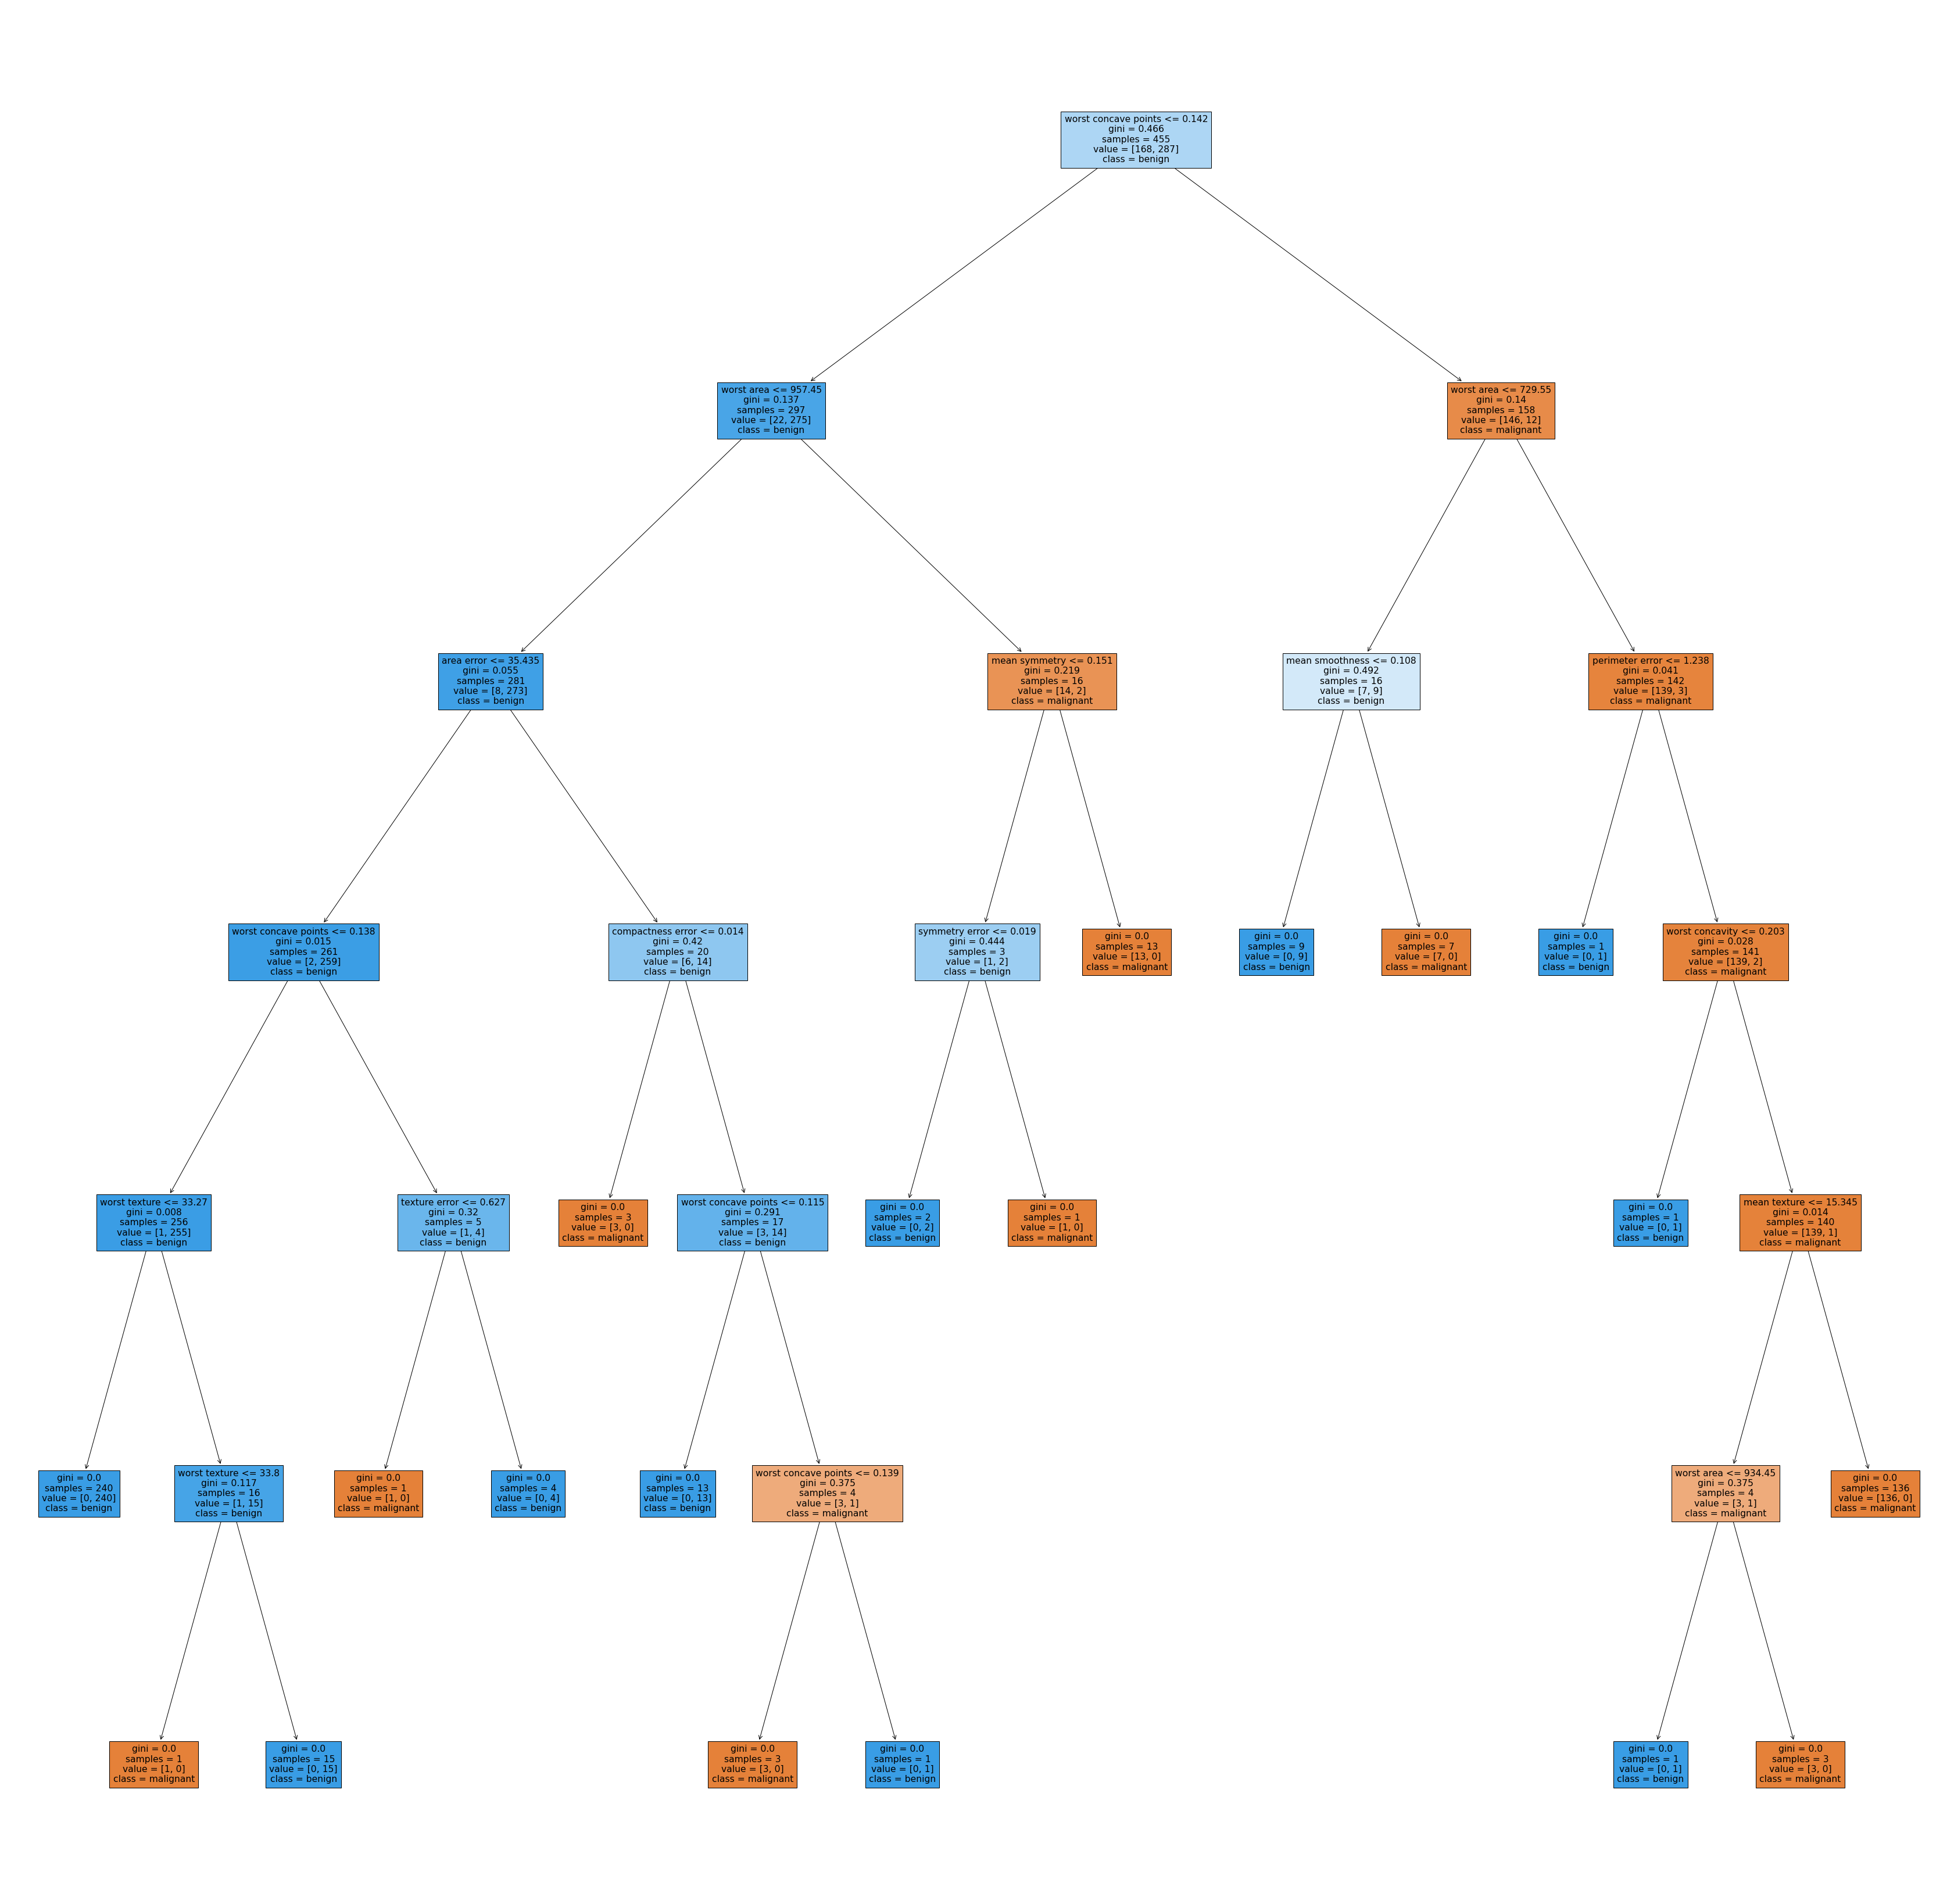

In [95]:
# create the model, initializing decision tree classifier
clf_tree = tree.DecisionTreeClassifier(random_state = 20)

# train the model, i.e., fit the data
clf_tree = clf_tree.fit(X_train, y_train)

# plot the tree
plt.figure(figsize=(60, 60))
tree.plot_tree(clf_tree, filled = True, feature_names=df.feature_names, class_names=df.target_names)
plt.show()

accuracy: 0.9298245614035088

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91        44
           1       0.93      0.96      0.94        70

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114


Confusion Matrix:
 [[39  5]
 [ 3 67]]
ROC-AUC Score: 0.9217532467532469


<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

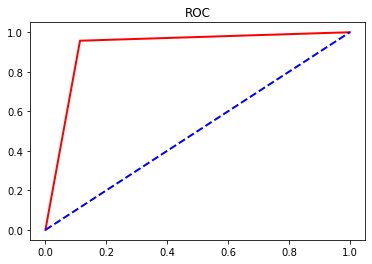

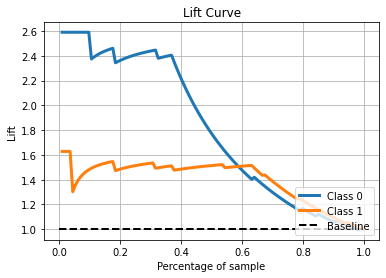

In [96]:
# generate prediction on testing set
y_pred = clf_tree.predict(X_test)

# prepare the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", confusion)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  # Replace y_pred with predicted probabilities
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# plot the ROC curve
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.title('ROC')

# plot the lift curve
y_probas = clf_tree.predict_proba(X_test) # use the classifier to predict probabilities on the test set
skplt.metrics.plot_lift_curve(y_test, y_probas, title='Lift Curve') # plot the lift curve

### Summary for ROC and lift curve:  
1. The AUC score is about 0.9218, which means the model has a good performance to assign a higher predictied probability to a randomly chosen postitive instance (note that the positive instance here is 1, which is Benign).  
2. Lift curves shows that, for Benign instances (class 1), roughly the top 5% predictions are about 1.6x as good at pedicting the outcome as random guess, and the top 60% predictions are about 1.5x as good at pedicting the outcome as random guess.
3. And for class 0 (Malignant instances), roughly the top 10% predictions are about 2.6x as good at pedicting the outcome as random guess, and the top 40% predictions are about 2.4x as good at pedicting the outcome as random guess, which is great since we tend to want to detect as more malignant cases as possible.

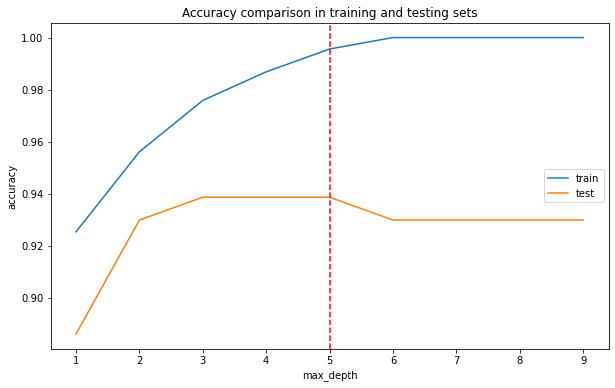

In [97]:
# Optimize and detect (potential) over-fitting

# try maximum depths from 1 to 0
complexity_values = range(1, 10)

# initialize empty lists to hold my accuracies
train_accuracies = []
test_accuracies=[]

# go through each complexity_value one at a time
for complexity_value in complexity_values:
    # create an empty tree with a specific maximum depth (complexity)
    clf_tree = tree.DecisionTreeClassifier(criterion = "gini", max_depth = complexity_value, random_state = 30)
    # train the model, i.e., fit the data
    clf_tree.fit(X_train, y_train)

    # prediction on training set and testing set
    y_train_pred = clf_tree.predict(X_train)
    y_test_pred = clf_tree.predict(X_test)
    
    # calculate accuracy for training and testing datasets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # append accuracy scores to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
# plot the results
plt.figure(figsize=(10, 6))
plt.plot(complexity_values, train_accuracies, label='train_accuracies')
plt.plot(complexity_values, test_accuracies, label='test_accuracies')
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.axvline(x = 5, color = 'red', linestyle = '--')
plt.title('Accuracy comparison in training and testing sets')
plt.legend(('train', 'test'), loc = 'center right')
plt.show()

### Summary for decision tree model:  
1. From the mannual hyperparameter tuning above, overfitting occurs when max_depth > 5 since testing accuracy falls in the range max_depth = [5, 6] while training accuracy keeps increasing in max_depth = [5, 6], as shown in the plot with a red vertical line. So 5 is the optimal value for hyperparameter max_depth to avoid overfitting problem, and max_depth < 5 is underfitting, given this training-testing split. 
2. All the metrics including accuracy, precision, recall, f-measure score are quite high, indicating the effectiveness of the model. 
3. The lift curves don't show significant problems to concern, and it can perform better in detecting Malignant instances.

## kNN

In [98]:
# specify the desired number of neighbors for kNN classifier, which is a hyper parameter
n_neighbors = 3

# create the model, note that it WILL include itself as one of the NN!!!
clf_knn = neighbors.KNeighborsClassifier(n_neighbors)

# apart from the number of neighbors, can also specify the distance metric to be used
# wikipedia entry for k-nearest neighbors classifier: http://en.wikipedia.org/wiki/K-nearest_neighbor_algorithm

# train the model (fit the data)
clf_knn = clf_knn.fit(X_train_scaled, y_train)

accuracy: 0.9824561403508771

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        44
           1       0.97      1.00      0.99        70

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion Matrix:
 [[42  2]
 [ 0 70]]
ROC-AUC Score: 0.9772727272727273


<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

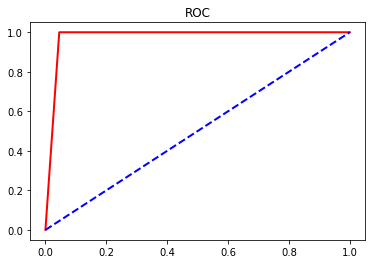

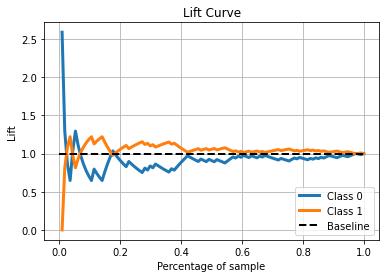

In [99]:
# generate prediction on testing set
y_pred = clf_knn.predict(X_test_scaled)

# prepare the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", confusion)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  # Replace y_pred with predicted probabilities
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# plot the ROC curve
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.title('ROC')

# plot the lift curve
y_probas = clf_knn.predict_proba(X_test) # use the classifier to predict probabilities on the test set
skplt.metrics.plot_lift_curve(y_test, y_probas, title='Lift Curve') # plot the lift curve

### Summary for ROC and lift curve:  
1. The AUC score is about 0.9773, which means the model has a great performance to assign a higher predictied probability to a randomly chosen postitive instance (note that the positive instance here is 1, which is Benign).  
2. Lift curves shows that it's not stable for the 2 classes; for class 0 (Malignant instance), the top 2% predictions are about 2.5x as good at pedicting the outcome as random guess, yet for class 1 (Benign instance), it performs even worse than a random model.

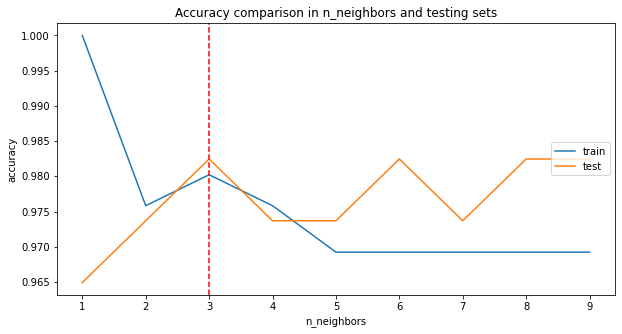

In [100]:
# Optimize and detect (potential) over-fitting

# try number of neighbors from 1 to 20
complexity_values = range(1, 10)

# initialize empty lists to hold my accuracies
train_accuracies = []
test_accuracies=[]

# go through each complexity_value one at a time
for complexity_value in complexity_values:
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors = complexity_value)
    clf_knn.fit(X_train_scaled, y_train)
    
    y_train_pred = clf_knn.predict(X_train_scaled)
    y_test_pred = clf_knn.predict(X_test_scaled)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# plot the results
plt.figure(figsize=(10, 5))
plt.plot(complexity_values, train_accuracies, label='train_accuracies')
plt.plot(complexity_values, test_accuracies, label='test_accuracies')
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.axvline(x = 3, color = 'red', linestyle = '--')
plt.title('Accuracy comparison in n_neighbors and testing sets')
plt.legend(('train', 'test'), loc = 'center right')
plt.show()

### Summary for kNN model:  
1. The performance of kNN model on testing set is relatively unstable compared to others two, it fluctuates after the hyperparameter n_neighbors>3. 
2. When n_neighbors>3, there could be chances that testing accuracy falls as shown, like from n_neighbors=3 to n_neighbors=4 there's an overfitting problem; although both accuracies are decreasing, accuracy in testins set decreases faster than that in training set.
3. The underfitting problem happens when n_neighbors<3 since testing accuracy could still increase within that range. 
4. Considering all above, I would say n_neighbors=3 is the optimized value for this model, given this training-testing split setting.  
(Note that the magnitude of y-axis is relatively smaller than the previous 2 models)
5. The lift curves might indicate the performance of the model is not quite stable.

## Logistic Regression

In [101]:
# create the model, initializing logistic regression classifier
clf_log = linear_model.LogisticRegression(C=1e5, multi_class='auto', solver ='saga', random_state=30)
# c is a hyper parameter
# c is the inverse of regularization strength; must be a positive float. Like in support vector machines, 
# smaller values specify stronger regularization

# in the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is
# set to ‘ovr’ and uses the cross-entropy loss, if the ‘multi_class’ option is set to ‘multinomial’. 

# train the model, i.e., fit the data
clf_log = clf_log.fit(X_train_scaled, y_train)

accuracy: 0.9736842105263158

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.97      0.99      0.98        70

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Confusion Matrix:
 [[42  2]
 [ 1 69]]
ROC-AUC Score: 0.9701298701298702


<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

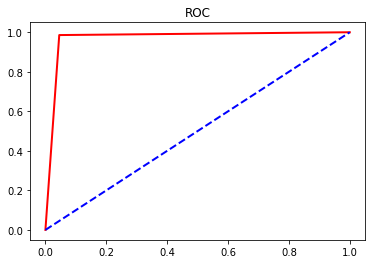

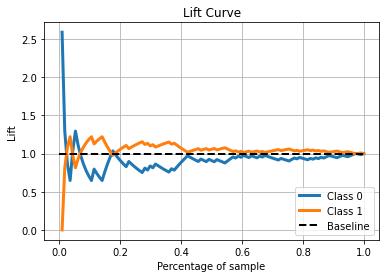

In [102]:
# generate prediction on testing set
y_pred = clf_log.predict(X_test_scaled)

# prepare the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", confusion)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # Replace y_pred with predicted probabilities
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# plot the ROC curve
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.title('ROC')

# plot the lift curve
y_probas = clf_log.predict_proba(X_test) # use the classifier to predict probabilities on the test set
skplt.metrics.plot_lift_curve(y_test, y_probas, title='Lift Curve') # plot the lift curve

### Summary for ROC and lift curve:  
1. The AUC score is about 0.9701, which means the model has a great performance to assign a higher predictied probability to a randomly chosen postitive instance (note that the positive instance here is 1, which is Benign).  
2. Lift curves shows that it's not stable for the 2 classes, just resembles that in kNN; for class 0 (Malignant instance), the top 2% predictions are about 2.5x as good at pedicting the outcome as random guess, yet for class 1 (Benign instance), it performs even worse than a random model.

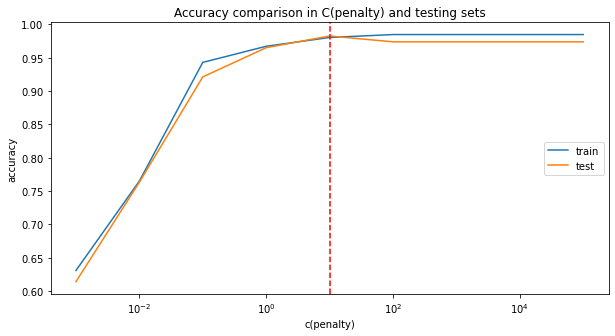

In [103]:
# Optimize and detect (potential) over-fitting

complexity_values = [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001]

# initialize empty lists to hold my accuracies
train_accuracies = []
test_accuracies=[]

# go through each complexity_value one at a time
for complexity_value in complexity_values:
    # Create an instance of the LogisticRegression classifier with the current value of C
    clf_log = linear_model.LogisticRegression(C = complexity_value, penalty='l2', multi_class='auto', solver ='saga', tol=0.01, random_state=20)
    clf_log.fit(X_train_scaled, y_train)
    
    y_train_pred = clf_log.predict(X_train_scaled)
    y_test_pred = clf_log.predict(X_test_scaled)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(complexity_values, train_accuracies, label='train_accuracies')
plt.plot(complexity_values, test_accuracies, label='test_accuracies')
plt.xscale('log')  # Use a logarithmic scale for the x-axis (C values)
plt.xlabel("c(penalty)")
plt.ylabel("accuracy")
plt.axvline(x = 10, color = 'red', linestyle = '--')
plt.title('Accuracy comparison in C(penalty) and testing sets')
plt.legend(('train', 'test'), loc = 'center right')
plt.show()

### Summary for logistic regression model:  
1. Logistic regression model performs even better than decision tree, with all the metrics perform above 0.9, indeicating that logistic regression might be a better model for this dataset. 
2. As shown in the plot, a red vertical line on x=10, which is the optimized C(penalty) hyperparameter, since when C>10 testing accuracy falls while training accuracy keeps increasing, which is an overfitting problem. And C<10 is where underfitting occurs since accuracy of testing set could still increase within this range. 
3. The lift curves might indicate the performance of the model is not quite stable.

## SVM

Here I will try svm models with different kernels or functions: linear kernel, rbf kernel, polynomial kernel, svm.LinearSVC

In [104]:
# create svm models with different kernels then train the model, i.e., fit the data
ln_svc = svm.SVC(kernel='linear', C = 1, probability=True).fit(X_train_scaled, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=1, probability=True).fit(X_train_scaled, y_train)
poly_svc = svm.SVC(kernel='poly', degree=3, C=1, probability=True).fit(X_train_scaled, y_train)
lin_svc = svm.LinearSVC(C=1).fit(X_train_scaled, y_train)

# C is a hyper parameter, set C = 1 here
# C is the inverse of regularization strength; must be a positive float. Like in support vector machines, 
# smaller values specify stronger regularization

linear kernel

accuracy: 0.956140350877193
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        44
           1       0.93      1.00      0.97        70

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix:
 [[39  5]
 [ 0 70]]
rbf kernel

accuracy: 0.9649122807017544
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        44
           1       0.95      1.00      0.97        70

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

Confusion Matrix:
 [[40  4]
 [ 0 70]]
polynomial kernel

accuracy: 0.9824561403508771
Classification Report:
               precision    recall  f1-score   support

           

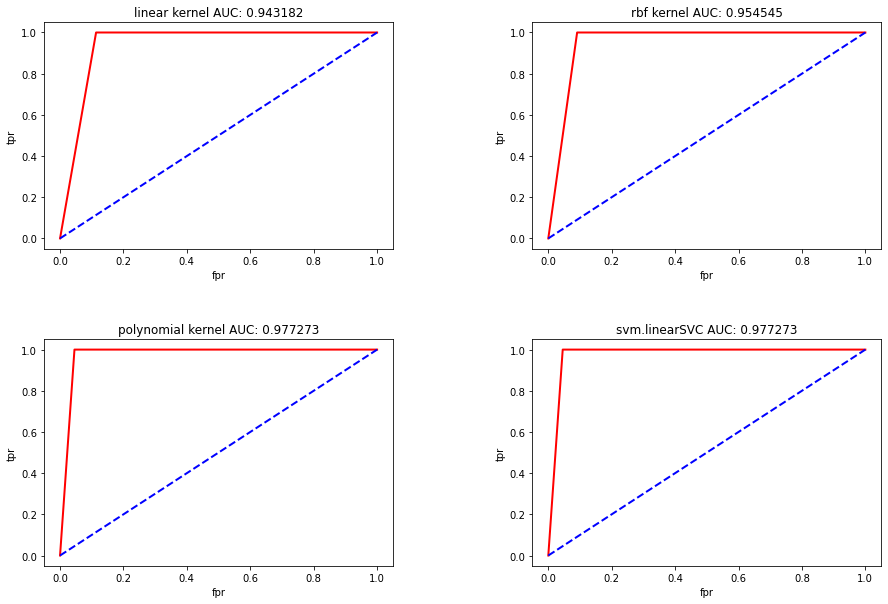

In [105]:
# generate prediction on testing set
y_pred_ln = ln_svc.predict(X_test_scaled)
y_pred_rbf = rbf_svc.predict(X_test_scaled)
y_pred_poly = poly_svc.predict(X_test_scaled)
y_pred_lin = lin_svc.predict(X_test_scaled)

# prepare the confusion matrix
# y_predictions list and name list
y_predictions = [y_pred_ln, y_pred_rbf, y_pred_poly, y_pred_lin]

svc_names = ['linear kernel', 'rbf kernel', 'polynomial kernel', 'svm.linearSVC']

# using subplot
fig = plt.figure(figsize=(15, 10))

for i in range(4):
    accuracy = accuracy_score(y_test, y_predictions[i])
    report = classification_report(y_test, y_predictions[i])
    confusion = confusion_matrix(y_test, y_predictions[i])

    print(svc_names[i])
    print("\naccuracy:", accuracy)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", confusion)
    print('==============================================================')

    fpr, tpr, thresholds = roc_curve(y_test, y_predictions[i])  # Replace y_pred with predicted probabilities
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(str(svc_names[i])+' AUC: '+str(round(roc_auc, 6)))

<AxesSubplot:title={'center':'Lift Curve: linear kernel'}, xlabel='Percentage of sample', ylabel='Lift'>

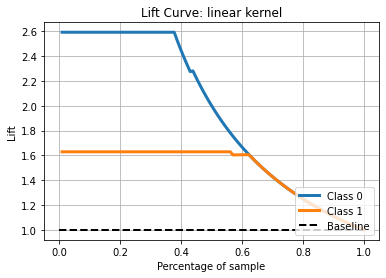

In [106]:
# prediction in probability to get the lift curve
y_pred_proba_ln = ln_svc.predict_proba(X_test_scaled)
skplt.metrics.plot_lift_curve(y_test, y_pred_proba_ln, title='Lift Curve: linear kernel') # plot the lift curve

<AxesSubplot:title={'center':'Lift Curve: rbf kernel'}, xlabel='Percentage of sample', ylabel='Lift'>

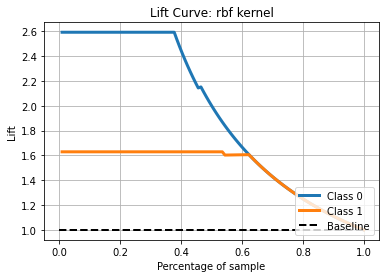

In [107]:
y_pred_proba_rbf = rbf_svc.predict_proba(X_test_scaled)
skplt.metrics.plot_lift_curve(y_test, y_pred_proba_rbf, title='Lift Curve: rbf kernel') # plot the lift curve

<AxesSubplot:title={'center':'Lift Curve: polynomial kernel'}, xlabel='Percentage of sample', ylabel='Lift'>

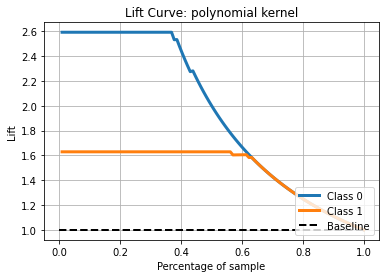

In [108]:
y_pred_proba_poly = poly_svc.predict_proba(X_test_scaled)
skplt.metrics.plot_lift_curve(y_test, y_pred_proba_poly, title='Lift Curve: polynomial kernel') # plot the lift curve

# svm.linearSVC doesn't have predict_proba() so skip

### Summary for ROC and lift curve:  
1. The AUC scores for all the kernel are above 0.9, which means the model has a great performance to assign a higher predictied probability to a randomly chosen postitive instance (note that the positive instance here is 1, which is Benign).  
2. Lift curves show that for class 0 (Malignant instances), roughly the top 40% predictions are about 2.6x as good at pedicting the outcome as random guess, and for class 1 (Benign instances) the top 60% predictions are about 1.6x as good at pedicting the outcome as random guess. 
3. The model could perform good especially in detecting Malignant instances, which is great since we tend to want to detect as more malignant cases as possible.

I did the detection of over-fitting for the 4 svm models.

In [109]:
# set up the list of penalty I want to iterate through
complexity_values = [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001]

#### for linear kernel

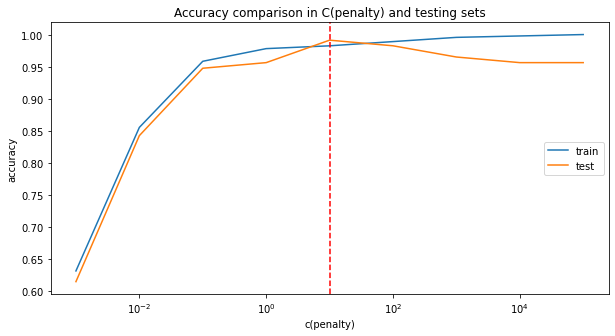

In [110]:
# Optimize and detect (potential) over-fitting

# initialize empty lists to hold my accuracies
train_accuracies = []
test_accuracies=[]

# go through each complexity_value one at a time
for complexity_value in complexity_values:
    # Create an instance of the LogisticRegression classifier with the current value of C
    ln_svc = svm.SVC(kernel = 'linear', gamma = 0.7, C = complexity_value)
    ln_svc.fit(X_train_scaled, y_train)
    
    y_train_pred = ln_svc.predict(X_train_scaled)
    y_test_pred = ln_svc.predict(X_test_scaled)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(complexity_values, train_accuracies, label='train_accuracies')
plt.plot(complexity_values, test_accuracies, label='test_accuracies')
plt.xscale('log')  # Use a logarithmic scale for the x-axis (C values)
plt.xlabel("c(penalty)")
plt.ylabel("accuracy")
plt.axvline(x = 10, color = 'red', linestyle = '--')
plt.title('Accuracy comparison in C(penalty) and testing sets')
plt.legend(('train', 'test'), loc = 'center right')
plt.show()

#### for rbf kernel

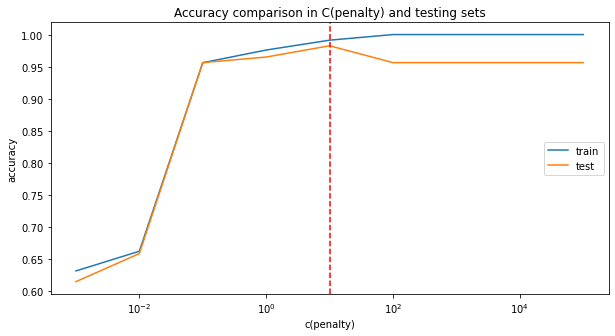

In [111]:
# Optimize and detect (potential) over-fitting

# initialize empty lists to hold my accuracies
train_accuracies = []
test_accuracies=[]

# go through each complexity_value one at a time
for complexity_value in complexity_values:
    # Create an instance of the LogisticRegression classifier with the current value of C
    rbf_svc = svm.SVC(kernel = 'rbf', gamma = 0.7, C = complexity_value)
    rbf_svc.fit(X_train_scaled, y_train)
    
    y_train_pred = rbf_svc.predict(X_train_scaled)
    y_test_pred = rbf_svc.predict(X_test_scaled)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(complexity_values, train_accuracies, label='train_accuracies')
plt.plot(complexity_values, test_accuracies, label='test_accuracies')
plt.xscale('log')  # Use a logarithmic scale for the x-axis (C values)
plt.xlabel("c(penalty)")
plt.ylabel("accuracy")
plt.axvline(x = 10, color = 'red', linestyle = '--')
plt.title('Accuracy comparison in C(penalty) and testing sets')
plt.legend(('train', 'test'), loc = 'center right')
plt.show()

#### for polynomial kernel

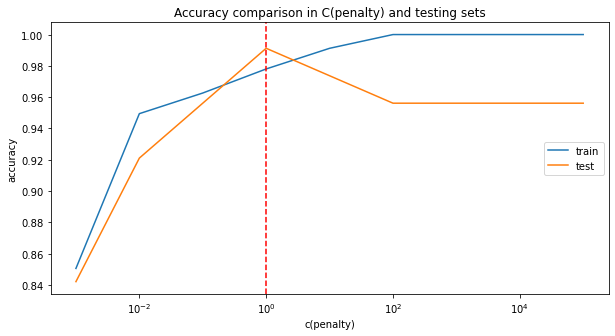

In [112]:
# Optimize and detect (potential) over-fitting

# initialize empty lists to hold my accuracies
train_accuracies = []
test_accuracies=[]

# go through each complexity_value one at a time
for complexity_value in complexity_values:
    # Create an instance of the LogisticRegression classifier with the current value of C
    poly_svc = svm.SVC(kernel = 'poly', gamma = 0.7, C = complexity_value)
    poly_svc.fit(X_train_scaled, y_train)
    
    y_train_pred = poly_svc.predict(X_train_scaled)
    y_test_pred = poly_svc.predict(X_test_scaled)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(complexity_values, train_accuracies, label='train_accuracies')
plt.plot(complexity_values, test_accuracies, label='test_accuracies')
plt.xscale('log')  # Use a logarithmic scale for the x-axis (C values)
plt.xlabel("c(penalty)")
plt.ylabel("accuracy")
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.title('Accuracy comparison in C(penalty) and testing sets')
plt.legend(('train', 'test'), loc = 'center right')
plt.show()

#### for linearSVC

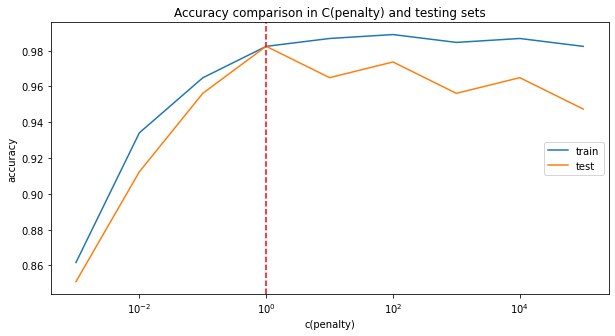

In [113]:
# Optimize and detect (potential) over-fitting

# gnore warnings about converging problems here
import warnings
warnings.filterwarnings('ignore')

# initialize empty lists to hold my accuracies
train_accuracies = []
test_accuracies=[]

# go through each complexity_value one at a time
for complexity_value in complexity_values:
    # Create an instance of the LogisticRegression classifier with the current value of C
    lin_svc = svm.LinearSVC(C = complexity_value)
    lin_svc.fit(X_train_scaled, y_train)
    
    y_train_pred = lin_svc.predict(X_train_scaled)
    y_test_pred = lin_svc.predict(X_test_scaled)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(complexity_values, train_accuracies, label='train_accuracies')
plt.plot(complexity_values, test_accuracies, label='test_accuracies')
plt.xscale('log')  # Use a logarithmic scale for the x-axis (C values)
plt.xlabel("c(penalty)")
plt.ylabel("accuracy")
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.title('Accuracy comparison in C(penalty) and testing sets')
plt.legend(('train', 'test'), loc = 'center right')
plt.show()

### Summary for SVM:  
1. Svm also perform well for this dataset, with almost all the metrics perform above 0.9.
2. As shown in the plot, a red vertical line on C=10, 10, 1, 1 for the linear, rbf, polynomial kernels and svm.LinearSVC, respectively, indicates where the over-fitting problem occurs; while under-fitting occurs in the range of C smaller than that threshold. 
3. The lift curves don't show significant problems to concern, and it can perform better in detecting Malignant instances.

# Nested CV for Hyperparameter Tunung and Model Comparison

Here I would demenstrate selecting optimized hyperparameter then do model performance comparison on AUC score using nested cv.

In [114]:
# set up all the arguments

# number of random trials, here we just do once
num_trails = 10

# set up possible values of parameters to optimize over
dt_grid = {'criterion': ['entropy', 'gini'], 'max_depth': list(range(1, 20)), 'min_impurity_decrease': [0.1, 0.05, 0.01, 0.005]}
lr_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [1e5, 1e4, 1e3, 100, 1, 0.01, 0.0001, 0.00001], 'multi_class': ['auto'], 'solver': ['saga'], 'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
knn_grid = {'n_neighbors': list(range(1, 31))}
# note that I have 3 dictionaries of hyperparameters for svm
svm_tuned_parameters = [{'kernel': ['linear'], 'C': [1e4, 1e3, 100, 10, 1, 0.1, 0.01,0.001, 0.0001]}, 
                    {'kernel': ['rbf'], 'gamma': [1e4, 1e3, 100, 10, 1, 0.1, 0.01,0.001, 0.0001], 'C': [1e4, 1e3, 100, 10, 1, 0.1, 0.01,0.001, 0.0001]}, 
                    {'kernel': ['poly'], 'degree': [1, 2, 3, 4, 5, 6], 'C': [1e4, 1e3, 100, 10, 1, 0.1, 0.01,0.001, 0.0001]}]

# set up estimator
dt = tree.DecisionTreeClassifier()
lr = linear_model.LogisticRegression()
knn = neighbors.KNeighborsClassifier()
svc = svm.SVC()

# arrays to store non-nested scores
non_nested_dt_scores = np.zeros(num_trails)
non_nested_lr_scores = np.zeros(num_trails)
non_nested_knn_scores = np.zeros(num_trails)
non_nested_svm_scores = np.zeros(num_trails)

# arrays to store nested scores
dt_scores = np.zeros(num_trails)
lr_scores = np.zeros(num_trails)
knn_scores = np.zeros(num_trails)
svm_scores = np.zeros(num_trails)

# set scoring 
scoring = 'roc_auc'

In [115]:
# run the nested cross-vallidation
# note that for GridSearchCV, the argument 'refit' is True by default, so the optimized parameter will be fitted and retured

# appropriately ignore some warnings
import warnings
warnings.filterwarnings("ignore", message="l1_ratio parameter is only used when penalty is ")
warnings.filterwarnings("ignore", message="The max_iter was reached which means ")

for i in range(num_trails): 
    # choose cross-validation techniques for the inner and outer loops
    # e.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = i)

    # non-nested parameter search and scoring
    print('==================================================================')
    print('In GridSearch to find optimized hyperparameters: trail', i+1, '\n')
    dt_clf = GridSearchCV(estimator = dt, param_grid = dt_grid, scoring = scoring, cv = inner_cv, refit = True)
    dt_clf.fit(X_train_scaled, y_train)
    # print the best hyper parameters
    print('Decision Tree')
    print("Best Hyperparameters: ", dt_clf.best_params_)
    print("Best AUC: ", dt_clf.best_score_)
    non_nested_dt_scores[i] = dt_clf.best_score_

    knn_clf = GridSearchCV(estimator = knn, param_grid = knn_grid, scoring = scoring, cv = inner_cv, refit = True)
    knn_clf.fit(X_train_scaled, y_train)
    # print the best hyper parameters
    print('\nKNN')
    print("Best Hyperparameters: ", knn_clf.best_params_)
    print("Best AUC: ", knn_clf.best_score_)
    non_nested_knn_scores[i] = knn_clf.best_score_
    
    lr_clf = GridSearchCV(estimator = lr, param_grid = lr_grid, scoring = scoring, cv = inner_cv, refit = True)
    lr_clf.fit(X_train_scaled, y_train)
    # print the best hyper parameters
    print('\nLogistic Regression')
    print("Best Hyperparameters: ", lr_clf.best_params_)
    print("Best AUC: ", lr_clf.best_score_)
    non_nested_lr_scores[i] = lr_clf.best_score_

    svm_clf = GridSearchCV(estimator = svc, param_grid = svm_tuned_parameters, scoring = scoring, cv = inner_cv, refit = True)    
    svm_clf.fit(X_train_scaled, y_train)
    # print the best hyper parameters
    print('\nSVM')
    print("Best Hyperparameters: ", svm_clf.best_params_)
    print("Best AUC: ", svm_clf.best_score_)
    non_nested_svm_scores[i] = svm_clf.best_score_ 
    
    # nested cv with parameter opitmization 
    dt_score = cross_val_score(dt_clf, X = X_train_scaled, y = y_train, cv = outer_cv)
    dt_scores[i] = dt_score.mean()
    
    knn_score = cross_val_score(knn_clf, X = X_train_scaled, y = y_train, cv = outer_cv)
    knn_scores[i] = knn_score.mean()
    
    lr_score = cross_val_score(lr_clf, X = X_train_scaled, y = y_train, cv = outer_cv)
    lr_scores[i] = lr_score.mean()
    
    svm_score = cross_val_score(svm_clf, X = X_train_scaled, y = y_train, cv = outer_cv)
    svm_scores[i] = svm_score.mean()

In GridSearch to find optimized hyperparameters: trail 1 

Decision Tree
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 3, 'min_impurity_decrease': 0.01}
Best AUC:  0.9523225670892582

KNN
Best Hyperparameters:  {'n_neighbors': 6}
Best AUC:  0.9930374779971315

Logistic Regression
Best Hyperparameters:  {'C': 100000.0, 'l1_ratio': 0.3, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'saga'}
Best AUC:  0.9958340523227974

SVM
Best Hyperparameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best AUC:  0.997293118126899
In GridSearch to find optimized hyperparameters: trail 2 

Decision Tree
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 3, 'min_impurity_decrease': 0.01}
Best AUC:  0.9436237902760887

KNN
Best Hyperparameters:  {'n_neighbors': 8}
Best AUC:  0.9902948504442783

Logistic Regression
Best Hyperparameters:  {'C': 100, 'l1_ratio': 0.1, 'multi_class': 'auto', 'penalty': 'elasticnet', 'solver': 'saga'}
Best AUC:  0.9925433399166117

SVM
Best Hyperparame

Then print out the score from nested cross-validation on the retained testing set:

In [116]:
print('In nested CV:\n')
print('Mean of decision tree score in nested cv: ', dt_scores.mean())
print('Mean of logistic regression score in nested cv: ', lr_scores.mean())
print('Mean of kNN score in nested cv: ', knn_scores.mean())
print('Mean of SVM score in nested cv: ', svm_scores.mean())

In nested CV:

Mean of decision tree score in nested cv:  0.9391516964813007
Mean of logistic regression score in nested cv:  0.9916040042531528
Mean of kNN score in nested cv:  0.9872545740091354
Mean of SVM score in nested cv:  0.9892086431417597


In [117]:
print('In nested CV:\n')
print('Standard deviation of decision tree score in nested cv: ', round(dt_scores.std(), 6))
print('Standard deviation of logistic regression score in nested cv: ', round(lr_scores.std(), 6))
print('Standard deviation of kNN score in nested cv: ', round(knn_scores.std(), 6))
print('Standard deviation of SVM score in nested cv: ', svm_scores.std()) # this is too small, approximately 0

In nested CV:

Standard deviation of decision tree score in nested cv:  0.006555
Standard deviation of logistic regression score in nested cv:  0.0018
Standard deviation of kNN score in nested cv:  0.002596
Standard deviation of SVM score in nested cv:  0.0043762566530673695


###  Summary
As shown, I used GridSearchCV to find optimized hyperparameter that I specified, and through the whole process, we can see that logistic regression seemed to the best performance (AUC: 0.9916) among the models with their own optimized hyperparameter settings, with the second best be SVM (AUC: 0.9892).

Yet for logistic and kNN models, the lift curves (presented in the previous sections) are not stable compared to the SVM and decision tree models, and this might indicates that the model performance fluctuates too much; meanwhile decision tree has the lowest AUC with the largest standard deviation, which is not a good choice obviously.  

Considering all the factors above, I choose SVM as my final model, with the second highest AUC (just 0.0024 lower), acceptable standard deviation, and much more stable lift curve.

## Do GridSearch again on the best model to optimize hyperparameters 
I did the GridSearch on SVM to tune the optomized hyperparameters

In [128]:
# set up all the arguments

# number of random trials, here we just do once
num_trails = 10

# set up possible values of parameters to optimize over
# note that I have 3 dictionaries of hyperparameters for svm
svm_tuned_parameters = [{'kernel': ['linear'], 'C': [1e4, 1e3, 100, 10, 1, 0.1, 0.01,0.001, 0.0001]}, 
                    {'kernel': ['rbf'], 'gamma': [1e4, 1e3, 100, 10, 1, 0.1, 0.01,0.001, 0.0001], 'C': [1e4, 1e3, 100, 10, 1, 0.1, 0.01,0.001, 0.0001]}, 
                    {'kernel': ['poly'], 'degree': [1, 2, 3, 4, 5, 6], 'C': [1e4, 1e3, 100, 10, 1, 0.1, 0.01,0.001, 0.0001]}]

# set up estimator
svc = svm.SVC(probability=True)

# arrays to store non-nested scores
non_nested_svm_scores = np.zeros(num_trails)

# arrays to store nested scores
svm_scores = np.zeros(num_trails)

# set scoring 
scoring = 'roc_auc'

# initialize empty lists to hold my accuracies
train_accuracy = 0
test_accuracy = 0

In [129]:
# note that for GridSearchCV, the argument 'refit' is True by default, so the optimized parameter will be fitted and retured

# appropriately ignore some warnings
import warnings
warnings.filterwarnings("ignore", message="l1_ratio parameter is only used when penalty is ")
warnings.filterwarnings("ignore", message="The max_iter was reached which means ")

# non-nested parameter search and scoring
'''lr_clf = GridSearchCV(estimator = lr, param_grid = lr_grid, scoring = scoring, cv = 5, refit = True)
lr_clf.fit(X_train_scaled, y_train)'''
svm_clf = GridSearchCV(estimator = svc, param_grid = svm_tuned_parameters, scoring = scoring, cv = 5, refit = True)    
svm_clf.fit(X_train_scaled, y_train)

y_train_pred = svm_clf.predict(X_train_scaled)
y_test_pred = svm_clf.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# print the best hyper parameters
print("Best Hyperparameters: ", svm_clf.best_params_)
print("Training set accuracy: ", train_accuracy)
print("Best score on validation: ", svm_clf.best_score_)
print("Testing set accuracy: ", test_accuracy)
print('Best estimator: ', svm_clf.best_estimator_)

Best Hyperparameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Training set accuracy:  0.9912087912087912
Best score on validation:  0.9948128665754371
Testing set accuracy:  0.9736842105263158
Best estimator:  SVC(C=10, gamma=1, probability=True)


## Present optimized model performance 

### Other metrics and confusion matrix

In [130]:
accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)
confusion = confusion_matrix(y_test, y_test_pred)

print("\naccuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)


accuracy: 0.9736842105263158
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.97      0.99      0.98        70

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
 [[42  2]
 [ 1 69]]


### ROC curve

Text(0.5, 1.0, 'SVM rbf kernel AUC: 0.97013')

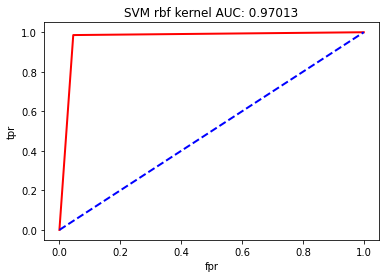

In [137]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)  # Replace y_pred with predicted probabilities
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('SVM rbf kernel AUC: '+ str(round(roc_auc, 6)))

### Lift curve

<AxesSubplot:title={'center':'Lift Curve: rbf kernel'}, xlabel='Percentage of sample', ylabel='Lift'>

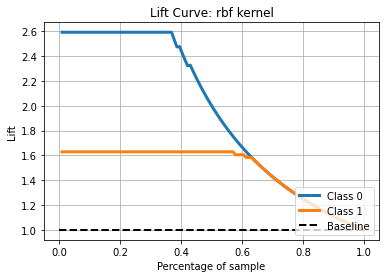

In [136]:
y_pred_proba = svm_clf.predict_proba(X_test_scaled)
skplt.metrics.plot_lift_curve(y_test, y_pred_proba, title='Lift Curve: rbf kernel') # plot the lift curve

# Summary  
1. class-while performances for optimized model are all above 0.95 in each metric presented above, indicating a good prediction ability for the SVM model in its optimized hyperparameters.   
2. SVM optomized hyperparameters are: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}.  
3. ROC and lift curve indicates no big problem in perfromance stability.  
4. Lift curves show that for class 0 (Malignant instances), roughly the top 40% predictions are about 2.6x as good at pedicting the outcome as random guess, and for class 1 (Benign instances) the top 60% predictions are about 1.6x as good at pedicting the outcome as random guess. The model could perform good especially in detecting Malignant instances, which is great since we tend to want to detect as more malignant cases as possible.